In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import pandas as pd
import tensorflow
import gzip
import numpy as np
import h5py
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, LSTM, Dense, InputLayer, Embedding
import numpy as np
import io

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [3]:
data_path = "/content/hin.txt"
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])

Jump.	उछलो.


In [4]:
lines = [line.split("\t") for line in lines]
print(lines[0])

['Help!', 'बचाओ!']


In [0]:
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

In [6]:
print(lines[5])

('\tHello!\n', '\tनमस्कार।\n')


In [0]:
english_lengths = np.array([len(line[0]) for line in lines])
hindi_lengths = np.array([len(line[1]) for line in lines])

In [8]:
print (len(english_lengths))

2869


(array([2.400e+02, 1.098e+03, 9.950e+02, 3.880e+02, 1.150e+02, 2.600e+01,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  7. ,  18.9,  30.8,  42.7,  54.6,  66.5,  78.4,  90.3, 102.2,
        114.1, 126. ]),
 <a list of 10 Patch objects>)

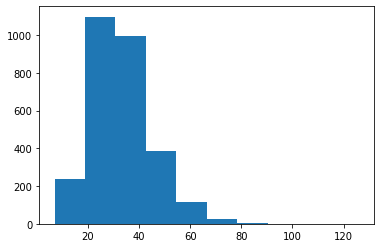

In [9]:
plt.hist(english_lengths)

(70.0, 80.0, 0.0, 200.0)

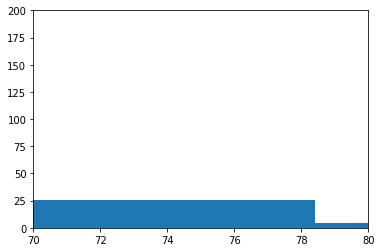

In [12]:
plt.hist(english_lengths)
plt.axis([70,80, 0 , 200])

(array([1.740e+02, 1.003e+03, 1.055e+03, 4.330e+02, 1.510e+02, 3.100e+01,
        1.800e+01, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  6. ,  17.7,  29.4,  41.1,  52.8,  64.5,  76.2,  87.9,  99.6,
        111.3, 123. ]),
 <a list of 10 Patch objects>)

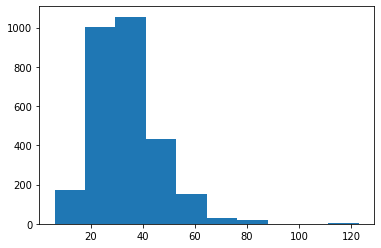

In [13]:
plt.hist(hindi_lengths)

(80.0, 89.0, 0.0, 50.0)

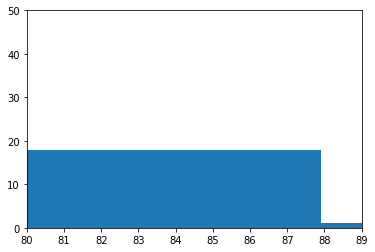

In [14]:
plt.hist(hindi_lengths)
plt.axis([80,89,0,50])

In [0]:
english = 78
hindi = 87

In [0]:
newline = []
for i in range(len(english_lengths)):
    if(english_lengths[i]<75 and hindi_lengths[i]<85):
        newline = newline + [lines[i]]
        

In [17]:
print (len(newline))

2856


In [0]:
batch_size = 64  
epochs = 100  
latent_dim = 256  
samples = 2869  

In [0]:
english_texts = [(line[0]) for line in newline]
hindi_texts = [(line[1]) for line in newline]

In [0]:
english_characters = set()
hindi_characters = set()

In [0]:
for english_text in english_texts:
    for char in english_text:
        if char not in english_characters:
            english_characters.add(char)

In [0]:
for hindi_text in hindi_texts:
    for char in hindi_text:
        if char not in hindi_characters:
            hindi_characters.add(char)

In [0]:
english_characters = sorted(list(english_characters))
hindi_characters = sorted(list(hindi_characters))
encoder_tokens = len(english_characters)
decoder_tokens = len(hindi_characters)
max_encoder = max([len(txt) for txt in english_texts])
max_decoder = max([len(txt) for txt in hindi_texts])

In [24]:
print('Number of samples:', len(english_texts))
print('Number of unique english tokens:', encoder_tokens)
print('Number of unique hindi tokens:', decoder_tokens)
print('Max sequence length for english:', max_encoder)
print('Max sequence length for hindi:', max_decoder)

Number of samples: 2856
Number of unique english tokens: 72
Number of unique hindi tokens: 92
Max sequence length for english: 74
Max sequence length for hindi: 82


In [0]:
english_token_index = dict([(char, i) for i, char in enumerate(english_characters)])
hindi_token_index = dict([(char, i) for i, char in enumerate(hindi_characters)])

In [0]:
encoder_english = np.zeros((len(english_texts), max_encoder, encoder_tokens),dtype='float32')
decoder_english = np.zeros((len(english_texts), max_decoder, decoder_tokens),dtype='float32')
decoder_hindi = np.zeros((len(english_texts), max_decoder, decoder_tokens),dtype='float32')

In [0]:
for i, (english_text, hindi_text) in enumerate(zip(english_texts, hindi_texts)):
    for t, char in enumerate(english_text):
        encoder_english[i, t, english_token_index[char]] = 1.
    for t, char in enumerate(hindi_text):
        decoder_english[i, t, hindi_token_index[char]] = 1.
        if t > 0:
          decoder_hindi[i, t - 1, hindi_token_index[char]] = 1.

In [0]:
encoder_eng = Input(shape=(None, encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_hin, state_h, state_c = encoder(encoder_eng)
encoder_states = [state_h, state_c]

In [0]:
decoder_eng = Input(shape=(None, decoder_tokens))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_hin, _, _ = decoder(decoder_eng,initial_state=encoder_states)
decoder_dense = Dense(decoder_tokens, activation='softmax')
decoder_hin = decoder_dense(decoder_hin)

In [0]:
model = Model([encoder_eng, decoder_eng], decoder_hin)

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [56]:
model.fit([encoder_english, decoder_hindi], decoder_hindi,batch_size=batch_size,epochs=5,validation_split=0.2)

Train on 2284 samples, validate on 572 samples
Epoch 1/5
2284/2284 [==============================] - 10s 4ms/sample - loss: 1.1969 - val_loss: 1.8123
Epoch 2/5
2284/2284 [==============================] - 8s 4ms/sample - loss: 0.9785 - val_loss: 1.3834
Epoch 3/5
2284/2284 [==============================] - 9s 4ms/sample - loss: 0.6669 - val_loss: 0.8338
Epoch 4/5
2284/2284 [==============================] - 8s 4ms/sample - loss: 0.3589 - val_loss: 0.3894
Epoch 5/5
2284/2284 [==============================] - 9s 4ms/sample - loss: 0.1463 - val_loss: 0.1428


In [0]:
model.load_weights('s8s.h5')

In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 72)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 336896      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  357376      input_4[0][0]                    
                                                                 lstm_2[0][1]               

In [0]:
encoder_model = Model(encoder_eng, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_hin, state_h, state_c = decoder(decoder_eng, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_hin = decoder_dense(decoder_hin)
decoder_model = Model([decoder_eng] + decoder_states_inputs,[decoder_hin] + decoder_states)

In [0]:
reverse_english_char_index = dict((i, char) for char, i in english_token_index.items())
reverse_hindi_char_index = dict((i, char) for char, i in hindi_token_index.items())

In [0]:
def decode(english_seq):
    states_value = encoder_model.predict(english_seq)
    hindi_seq = np.zeros((1, 1, decoder_tokens))
    hindi_seq[0, 0, hindi_token_index['\t']] = 1.
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        hindi_tokens, h, c = decoder_model.predict([hindi_seq] + states_value)
        sampled_token_index = np.argmax(hindi_tokens[0, -1, :])
        sampled_char = reverse_hindi_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder):
            stop_condition = True
        hindi_seq = np.zeros((1, 1, decoder_tokens))
        hindi_seq[0, 0, sampled_token_index] = 1.
        states_value = [h, c]
    return decoded_sentence

In [66]:
for seq in range(500):
   english_seq = encoder_english[seq: seq + 1]
   decoded_sentence = decode(english_seq)
   print("English:" + english_texts[seq])
   print("Hindi:         " + decoded_sentence)

English:	Help!

Hindi:         बचाओ!

English:	Jump.

Hindi:         उछलो.

English:	Jump.

Hindi:         उछलो.

English:	Jump.

Hindi:         उछलो.

English:	Hello!

Hindi:         नमस्कार।

English:	Hello!

Hindi:         नमस्कार।

English:	Cheers!

Hindi:         चियर्स!

English:	Cheers!

Hindi:         चियर्स!

English:	Got it?

Hindi:         समझे कि नहीं?

English:	I'm OK.

Hindi:         मैं ठीक हूँ।

English:	Awesome!

Hindi:         बहुत बढ़िया!

English:	Come in.

Hindi:         चलो छाया में थोड़ा आराम करलें।

English:	Get out!

Hindi:         बाहर निकल जाओ!

English:	Go away!

Hindi:         चले जाओ!

English:	Goodbye!

Hindi:         ख़ुदा हाफ़िज़।

English:	Perfect!

Hindi:         सही!

English:	Perfect!

Hindi:         सही!

English:	Welcome.

Hindi:         आपका स्वागत है।

English:	Welcome.

Hindi:         आपका स्वागत है।

English:	Have fun.

Hindi:         मज़े करना।

English:	Have fun.

Hindi:         मज़े करना।

English:	Have fun.

Hindi:         मज़े करना।

Engl